In [2]:
import os
from fig_gen  import FigureGenerator as fg
from sklearn.metrics import r2_score
import pwlf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
%matplotlib inline
import missingno as msno
np.random.seed(19)
from matplotlib.pyplot import figure
data_directory = '/work2/05067/nagyz/austin_energy/data/'
filepaths = [os.path.join(data_directory,f) for f in os.listdir(data_directory) if f.endswith('.csv')]
from datetime import datetime 
from Graphs import load_data,load_graph_kwh,yearly_graph_kwh,load_graph_count,monthly_graph_kwh,daily_graph_kwh,prepare_data,make_features
from Graphs import load_graph_kwh_and_count,yearly_graph_kwh_and_count,monthly_graph_kwh_and_count,daily_graph_kwh_and_count
from agg_and_heatmap_functions import length,prav3,prav2,prav1,dinostorm,plot_aggraph,heatmap,finalheatmap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
weather_daily=pd.read_csv('Austin_weather_daily.csv')
weather_daily['time']=pd.to_datetime(weather_daily['time'],utc=True)
weather_daily1=weather_daily.set_index('time',drop=True)
weather_austin_daily=weather_daily1['tavg']
cool_points=weather_austin_daily[weather_austin_daily<15]['2017-01-01 00:00:00+00:00':'2021-01-31 00:00:00+00:00']
# NOT UTC TIME
weather_Pred=pd.read_csv('Austin_hourly.csv')
weather_Pred['time']=pd.to_datetime(weather_Pred['time'])
weather_pred1=weather_Pred.set_index('time',drop=True)
weather_austin_hourl_pred=weather_pred1['temp']
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import SeasonalAD
from adtk.data import to_events

from adtk.detector import OutlierDetector
from sklearn.neighbors import LocalOutlierFactor

In [3]:
id_list = pd.read_csv('buildingInfo.csv')

#id_list.drop('Unnamed: 0',axis=1,inplace=True)
id_list['buildingType'].unique()
res_type = ['SINGLE FAMILY', 'MULTIFAMILY',  'FOURPLEX', 
            'DUPLEX', 'CONDOS', 'CONDO (STACKED)', 
            '1 FAM DWELLING, ACCESSORY DWELLING UNIT',
            'TOWNHOMES','MOHO SINGLE PP', 
            '1 FAM DWELLING, GARAGE APARTMENT', 'MOHO DOUBLE PP',
            'MOHO SINGLE REAL', 'MOHO DOUBLE REAL', 'TRIPLEX', 
            '1 FAM DWELLING, MOHO DOUBLE REAL',
           '1 FAM DWELLING, MOHO SINGLE REAL']
res_type_id_list = id_list[id_list['buildingType'].isin(res_type)].copy()


In [4]:
single_Famiy=res_type_id_list[res_type_id_list['buildingType']=='SINGLE FAMILY']
single_Famiy[single_Famiy['zipCode']==78758]

,Service Point,zipCode,rate,buildingType,meterCount,squareFt
29,-1583,78758,E-SEC2,SINGLE FAMILY,14,7042.125
30,-1582,78758,E-SEC1,SINGLE FAMILY,25,19913.375
31,-1581,78758,E-RES,SINGLE FAMILY,5363,8224307.500


In [5]:
def prepare_data(service_point):
    sample=load_data(service_point)
    sample=sample.set_index(sample[sample.columns[0]])
    sample=sample[sample.columns[1:2]]
    sample=sample.resample('D').sum()
    return sample
def make_features(dataframe,time_level):
    s=dataframe
    start_time=s.index[0]
    end_time=s.index[-1]
    example_ts=s
    example_ts['dayofyear_cos']=np.cos(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['dayofyear_sim']=np.sin(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['month_cos']=np.cos(example_ts.index.month*(2.*np.pi/12))
    example_ts['month_sin']=np.sin(example_ts.index.month*(2.*np.pi/12))
    example_ts['year'] = example_ts.index.year

    for ts in example_ts.index:
        if time_level=='hourly':
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts] 
        else:
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts]

    return example_ts

In [6]:
def preprocess_data(servicepoint):
    s=prepare_data(servicepoint)
    s = s.rename(columns={list(s.columns.values)[0]: 'Energy_kwh'})
    train_set=s['2018-01-01':'2021-02-10']
    test_set=s['2021-02-11':'2021-02-19']
    residential_train=make_features(train_set,'daily')
    residential_test=make_features(test_set,'daily')
    Q1=residential_train[residential_train.columns[0]].quantile(0.25)
    Q3=residential_train[residential_train.columns[0]].quantile(0.75)
    low_5=residential_train[residential_train['TMP']<=5]['Energy_kwh'].quantile(0.50)
    lower_bound=low_5
    IQR=Q3-Q1
    upper_bound=Q3+1.5*IQR
    if servicepoint==-1581:
        Index=residential_train[((residential_train['Energy_kwh'] <Q1 ) & (residential_train['TMP'] <=5))
                               | (residential_train['Energy_kwh'] >upper_bound )].index
    else:
        Index=residential_train[(residential_train['Energy_kwh'] <Q1 ) & (residential_train['TMP'] <0) ].index
    cleaned_train=residential_train.drop(Index,axis=0)
    cleaned_train1=pd.concat([cleaned_train,residential_test])
    return cleaned_train1
def prediction_model(service_point,visualize=True,calculate_metrics=True,metric=None):
    print('.....LOADING DATA.........')
    q=preprocess_data(service_point)[['Energy_kwh','TMP','year']]
    
    train_below_5=q[q['TMP']<=5][['Energy_kwh','TMP','year']][:'2021-02-10']
    train_above_5=q[q['TMP']>5][['Energy_kwh','TMP','year']][:'2021-02-10']

    
    m_below,b_below = np.polyfit(train_below_5['TMP'], train_below_5['Energy_kwh'], 1)
    if visualize:
        plt.scatter(train_below_5['TMP'], train_below_5['Energy_kwh'])
        plt.plot(train_below_5['TMP'], m_below*train_below_5['TMP'] +b_below,color='red')
        plt.show()
        print(train_below_5['TMP'].corr(train_below_5['Energy_kwh']))

    m_above,m1_above,b_above = np.polyfit(train_above_5['TMP'], train_above_5['Energy_kwh'], 2)
    if visualize:
        plt.scatter(train_above_5['TMP'], train_above_5['Energy_kwh'])
        plt.plot(train_above_5['TMP'], m_above*train_above_5['TMP']**2 + m1_above*train_above_5['TMP'] + b_above,color='red')
        plt.show()
        print(train_above_5['TMP'].corr(train_above_5['Energy_kwh']))
    
        print('...............VIZ DONE.............')
    
    test_below_5=q[q['TMP']<=5][['Energy_kwh','TMP','year']]
    test_above_5=q[q['TMP']>5][['Energy_kwh','TMP','year']]

    #SCALING 
    print('...........STARTED SCALING')
    scaler_below = MinMaxScaler()
    scaler_pred_below=MinMaxScaler()
    scaler_pred_below.fit(train_below_5[['Energy_kwh']])
    
    train_below_5_scaled = scaler_below.fit_transform(train_below_5.to_numpy())
    train_below_5_scaled = pd.DataFrame(train_below_5_scaled, columns=train_below_5.columns,index=train_below_5.index)
    
    test_below_5_scaled = scaler_below.transform(test_below_5.to_numpy())
    test_below_5_scaled = pd.DataFrame(test_below_5_scaled, columns=test_below_5.columns,index=test_below_5.index)
    
    scaler_above = MinMaxScaler()
    scaler_pred_above=MinMaxScaler()
    scaler_pred_above.fit(train_above_5[['Energy_kwh']])
    
    train_above_5_scaled = scaler_above.fit_transform(train_above_5.to_numpy())
    train_above_5_scaled = pd.DataFrame(train_above_5_scaled, columns=train_above_5.columns,index=train_above_5.index)
    
    test_above_5_scaled = scaler_above.transform(test_above_5.to_numpy())
    test_above_5_scaled = pd.DataFrame(test_above_5_scaled, columns=test_above_5.columns,index=test_above_5.index)
    
    print('..........SCALING DONE.........')
    
    ## FITTING
    
    Lr_below_5=LinearRegression().fit(train_below_5_scaled[train_below_5.columns[1:]], train_below_5_scaled[['Energy_kwh']])
    
    


    polynomial_features= PolynomialFeatures(degree=2)
    x_poly = polynomial_features.fit_transform(train_above_5_scaled[['TMP']])
    Lr_above_5=LinearRegression().fit(x_poly, train_above_5_scaled[['Energy_kwh']])

    
    print('...........FITTING DONE................')
    
    ## PREDICTION
    below_5_predictions_sc=scaler_pred_below.inverse_transform(Lr_below_5.predict(test_below_5_scaled[test_below_5_scaled.columns[1:]]))
    
    below_5_predictions=pd.DataFrame(below_5_predictions_sc,
                                     index=test_below_5_scaled.index)
    
    test_below_5_scaled2=pd.DataFrame(scaler_below.inverse_transform(test_below_5_scaled),columns=test_below_5_scaled.columns,
                                      index=test_below_5_scaled.index)
    below_5_predictions1=test_below_5_scaled2.merge(below_5_predictions,how='inner',left_index=True,right_index=True)
        
        
    
    test_x_poly = polynomial_features.fit_transform(test_above_5_scaled[['TMP']])
    above_5_predictions_sc=scaler_pred_above.inverse_transform(Lr_above_5.predict(test_x_poly))

    above_5_predictions=pd.DataFrame(above_5_predictions_sc,
                                     index=test_above_5_scaled.index)
    test_above_5_scaled2=pd.DataFrame(scaler_above.inverse_transform(test_above_5_scaled),columns=test_above_5_scaled.columns,
                                      index=test_above_5_scaled.index)
    
    above_5_predictions1=test_above_5_scaled2.merge(above_5_predictions,how='inner',left_index=True,right_index=True)
    
    ## JOINING EVERYTHING AND CONVERTING BACK
    total_predictions=pd.concat([above_5_predictions1,below_5_predictions1])[['Energy_kwh','TMP',0]]
    total_predictions1=total_predictions[total_predictions[0]>0].sort_index().rename(
                                                            columns={0: 'prediction'})
    total_predictions1['difference']=total_predictions1['prediction']-total_predictions1['Energy_kwh']
    print('...........GIVING YOU PREDCTIONS....:)')
    
    
    if calculate_metrics and metric:
        predic=total_predictions1['prediction']['2021-02-11':'2021-02-19']
        real=  total_predictions1['Energy_kwh']['2021-02-11':'2021-02-19']
        if metric=='perc_diff':
            result=100*(predic-real)/real
        elif metric=='difference(z_score)':
            metric_result=predic-real
            result=(metric_result-metric_result.mean())/metric_result.std()
        elif metric=='perc_diff(reverse)':
            result=100*(real-predic)/predic
        di=pd.DataFrame(result)
        di['timestamp']=di.index
        di1=di.rename(columns={0:service_point})
        return di1.reset_index().iloc[:,1:].set_index('timestamp',drop=True)
    else:
        return total_predictions1

.....LOADING DATA.........


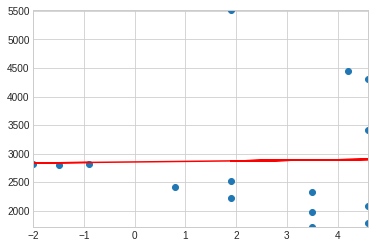

0.02019891499703551


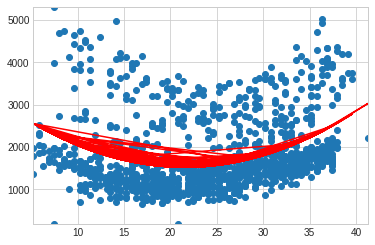

0.143297262248006
...............VIZ DONE.............
...........STARTED SCALING
..........SCALING DONE.........
...........FITTING DONE................
...........GIVING YOU PREDCTIONS....:)


,Energy_kwh,TMP,prediction,difference
-1583 kWh DateTime,,,,
2021-02-10,4990.402199,14.1,1734.213771,-3256.188428
2021-02-11,6726.203194,4.1,4557.942850,-2168.260343
2021-02-12,7226.377350,0.8,5402.502612,-1823.874738
2021-02-13,7238.172173,-0.4,5709.615252,-1528.556920
2021-02-14,7671.822403,-0.4,5709.615252,-1962.207151
2021-02-15,7038.653778,-5.9,7117.214854,78.561076
2021-02-16,5502.928398,-6.5,7270.771174,1767.842776
2021-02-17,5782.335770,-4.2,6682.138614,899.802844
2021-02-18,6769.274239,-1.5,5991.135173,-778.139066


In [22]:
new=prediction_model(-1583,visualize=True,calculate_metrics=False,metric=None)
new.tail(10)

In [23]:
new_diff=new[['difference']]['2018-01-01':'2021-02-19']
print(len(new_diff))

1145


In [24]:
new_diff = new_diff.resample('D').ffill()
print(len(new_diff))

1145


[<AxesSubplot:>]

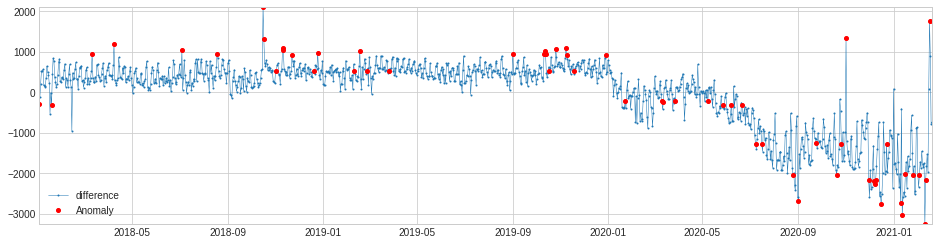

In [25]:
s_train = validate_series(new_diff)
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))
anomalies = outlier_detector.fit_detect(s_train)
plot(s_train, anomaly=anomalies, anomaly_color="red", anomaly_tag="marker")

In [26]:
anomalies['2021-02-10':]

-1583 kWh DateTime
2021-02-10     True
2021-02-11     True
2021-02-12    False
2021-02-13    False
2021-02-14    False
2021-02-15    False
2021-02-16     True
2021-02-17    False
2021-02-18    False
2021-02-19    False
Freq: D, dtype: bool